In [1]:
import os

# For fast CPU-only startup 
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import time
from ML4transients.data_access import DatasetLoader
from ML4transients.training import PytorchDataset
import pandas as pd
import numpy as np

print("Loading dataset...")
t0 = time.time()
dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_coadd_v2')
print(f"Dataset loaded in {time.time() - t0:.2f} seconds")


2025-12-02 15:55:32.333617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764687332.354931 3600185 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764687332.361369 3600185 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764687332.379268 3600185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764687332.379289 3600185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764687332.379291 3600185 computation_placer.cc:177] computation placer alr

Loading dataset...
Dataset loaded in 0.00 seconds


# Cutouts


In [2]:
dataset.get_dataset_statistics()

Discovering data files...
Data discovery completed in 0.00s: 146 cutout visits, 146 feature visits, 1 lightcurve paths
Computing dataset statistics...
Loaded lightcurve index with 3856539 objects

DATASET STATISTICS SUMMARY

Data Overview:
  Total visits: 146
  Data paths: 1
  Visits with cutouts: 146
  Visits with features: 146

Cutout Statistics:
  Total cutouts: 1,338,300
  Average per visit: 9166.4

Feature Statistics:
  Total features: 1,338,300
  Average per visit: 9166.4

Label Distribution:
  Total labeled sources: 1,338,300
  Injections: 0 (0.0%)
  Real sources: 1,338,300 (100.0%)

Lightcurve Statistics:
  Total objects: 3,856,539

Inference Results:
  Inference files: 0
  Models used: 0
  Visits with inference: 0



{'summary': {'num_visits': 146,
  'num_data_paths': 1,
  'total_cutouts': 1338300,
  'total_features': 1338300,
  'visits_with_cutouts': 146,
  'visits_with_features': 146,
  'avg_cutouts_per_visit': 9166.438356164384,
  'avg_features_per_visit': 9166.438356164384,
  'total_lightcurve_objects': 3856539},
 'per_visit': {},
 'labels': {'total_injections': 0,
  'total_real': 1338300,
  'total_labeled': 1338300,
  'injection_pct': 0.0,
  'real_pct': 100.0},
 'inference': {'total_inference_files': 0,
  'num_models': 0,
  'visits_with_inference': 0}}

Loading cutouts from visit 11694


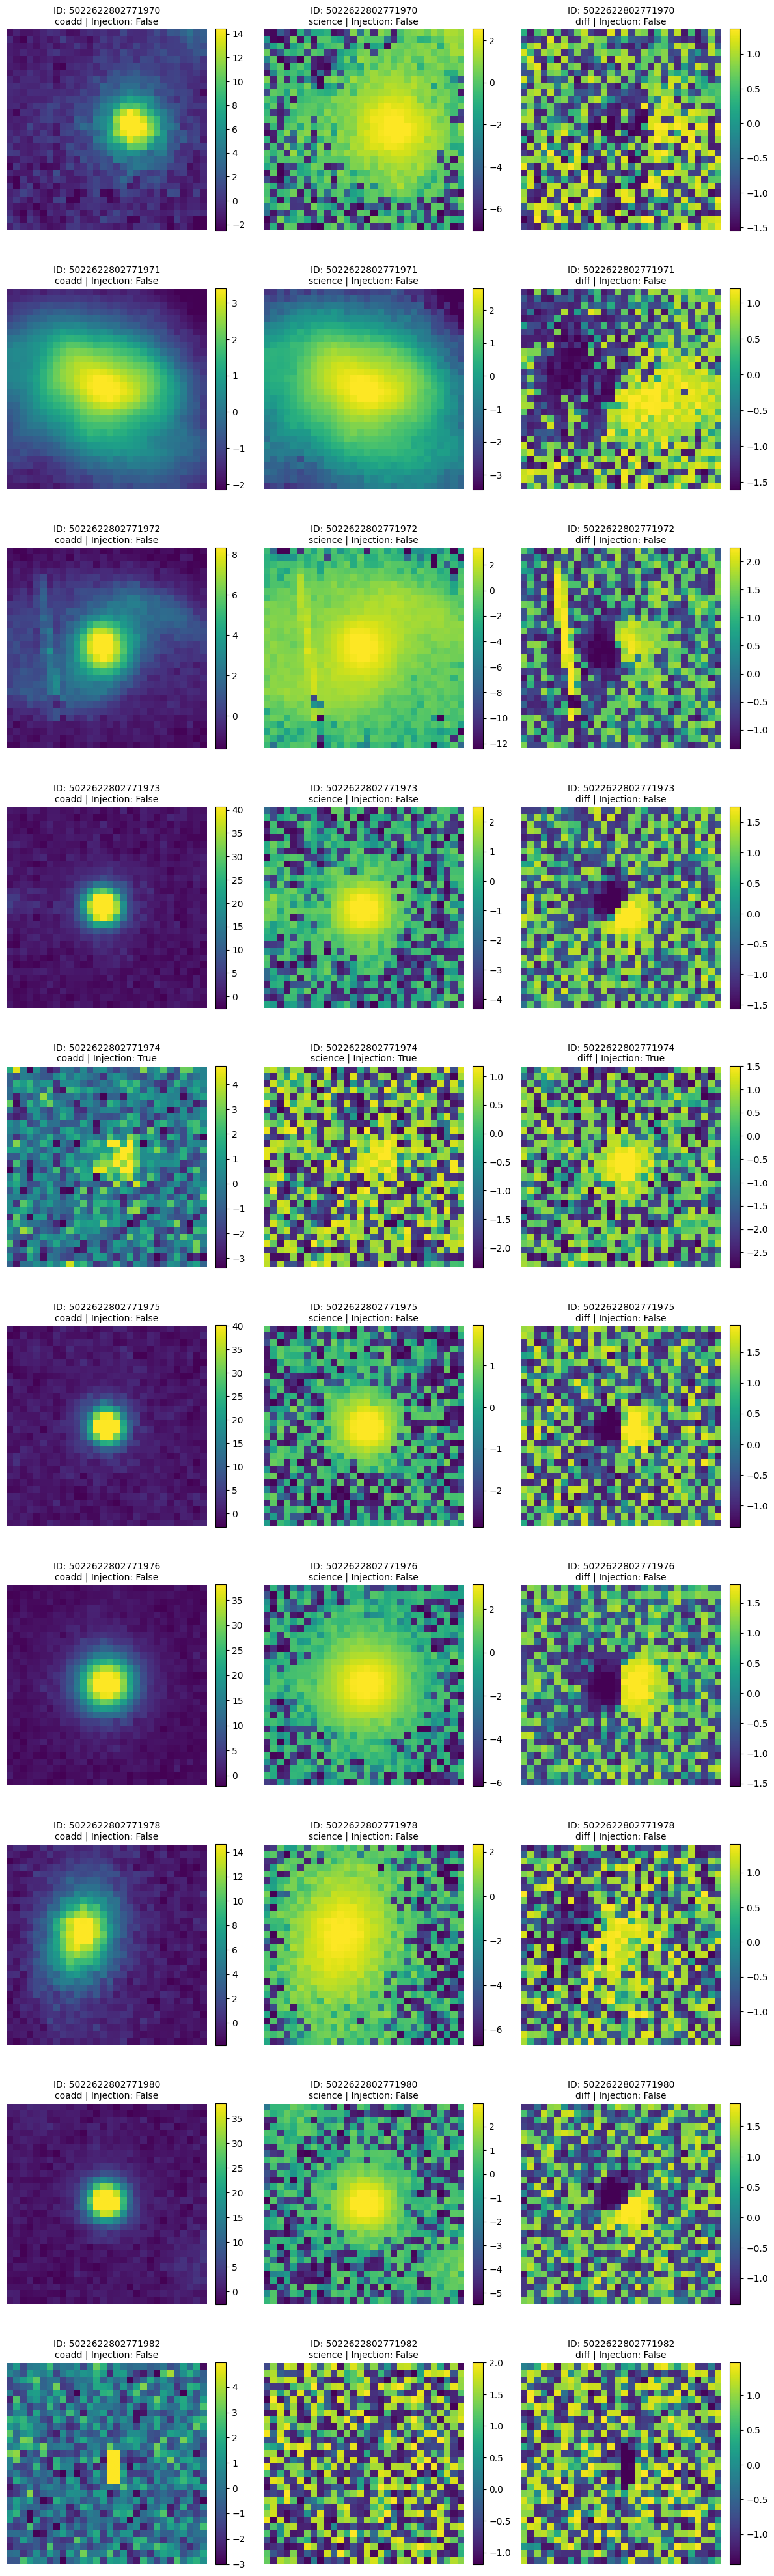

Cutout shape: (30, 30)
Value range: [-1.428, 1.470]


In [3]:
import matplotlib.pyplot as plt

first_visit = dataset.visits[12]
print(f"Loading cutouts from visit {first_visit}")

cutout_loader = dataset.cutouts[first_visit]
feature_loader = dataset.features[first_visit]
sample_ids = cutout_loader.ids[:10]  # show two DIA IDs

cutout_types = ['coadd','science', 'diff']

# rows = number of samples, columns = number of cutout types
n_rows = len(sample_ids)
n_cols = len(cutout_types)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))

for row_idx, dia_id in enumerate(sample_ids):
    features = feature_loader.get_by_id(dia_id)
    is_injection = features['is_injection'].iloc[0] if not features.empty else False

    for col_idx, cutout_type in enumerate(cutout_types):
        ax = axes[row_idx, col_idx] if n_rows > 1 else axes[col_idx]

        # Load cutout of a specific type
        cutout = cutout_loader.get_by_id(dia_id, cutout_type=cutout_type)

        im = ax.imshow(cutout,  origin='lower')
        ax.set_title(f'ID: {dia_id}\n{cutout_type} | Injection: {is_injection}', fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Optional diagnostics for one example
print(f"Cutout shape: {cutout.shape}")
print(f"Value range: [{cutout.min():.3f}, {cutout.max():.3f}]")


# LC visualization

In [4]:
dataset.lightcurves.plot_lightcurve(dia_object_id=3495914812699862335)

AttributeError: 'dict' object has no attribute 'plot_lightcurve'

In [ ]:
data_path = dataset.data_paths[0]
diasource_index_file = data_path / "lightcurves" / "diasource_patch_index.h5"
data_path

In [ ]:
diasource_index = pd.read_hdf(diasource_index_file, key='diasource_index')


In [ ]:
dia_object_id=3495901618560337471
sources_for_object = diasource_index[diasource_index['diaObjectId'] == dia_object_id]
len(sources_for_object)
sources_for_object

In [ ]:
sources_for_object.columns

In [ ]:
def plot_lc_cutout(dia_object_id, cutout_type="diff"): 
    sources_for_object = diasource_index[diasource_index['diaObjectId'] == dia_object_id]
    len(sources_for_object)
    sources_for_object
    # number of sources
    n = len(sources_for_object.index)
    if n>20: 
        print("too long")
        return 0
    # create subplots (1 row, n columns)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))  # adjust figsize as needed

    # ensure axes is iterable even if n=1
    if n == 1:
        axes = [axes]

    for ax, i in zip(axes, sources_for_object.index):
        img = dataset.get_cutout_by_id(i, cutout_type=cutout_type)
        ax.imshow(img)
        ax.axis('off')  # optional, hide axes
        ax.set_title(str(i))  # optional, label each cutout

    plt.tight_layout()
    plt.show()

In [ ]:
id=3496002773630107900
plot_lc_cutout(id, 'coadd')
plot_lc_cutout(id, 'science')
plot_lc_cutout(id, 'diff')

In [ ]:
plot_lc_cutout(sources_for_object, 'coadd')

In [ ]:
import matplotlib.pyplot as plt
for i in sources_for_object.index:
    plt.imshow(dataset.get_cutout_by_id(i, cutout_type='science'))
    plt.show()

# Lc inference

Discovering data files...
Data discovery completed in 0.01s: 146 cutout visits, 146 feature visits, 1 lightcurve paths
Loaded SNN inference data: 3856539 total lightcurves
  SNN processed: 336 lightcurves
  Not processed (failed filtering): 3856203 lightcurves
  Processing rate: 0.0%

SNN Inference Source Count Statistics:
  Mean sources per lightcurve: 19.3
  Min sources: 6
  Max sources: 116

VALIDATING SNN FILTERING CONSISTENCY
Checking 100 SNN-processed lightcurves against filtering criteria...
Loaded lightcurve index with 3856539 objects
Validation passed: All sampled objects meet filtering criteria


SNN-processed objects: 336
Non-SN: 21 (6.2%)
Supernova: 315 (93.8%)

Uncertainty Statistics:
Mean SN probability uncertainty: 0.146
High uncertainty objects (std > 0.1): 223

High-confidence SN (mean prob > 0.7): 212
High-confidence + Low uncertainty (std < 0.05): 20

Top 5 candidates (by mean probability):
NOTE: Lightcurve statistics shown below are from the current HDF5 files,
    

/sps/lsst/users/rbonnetguerrini/ML4transients/src/ML4transients/data_access/data_loaders.py:1833: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


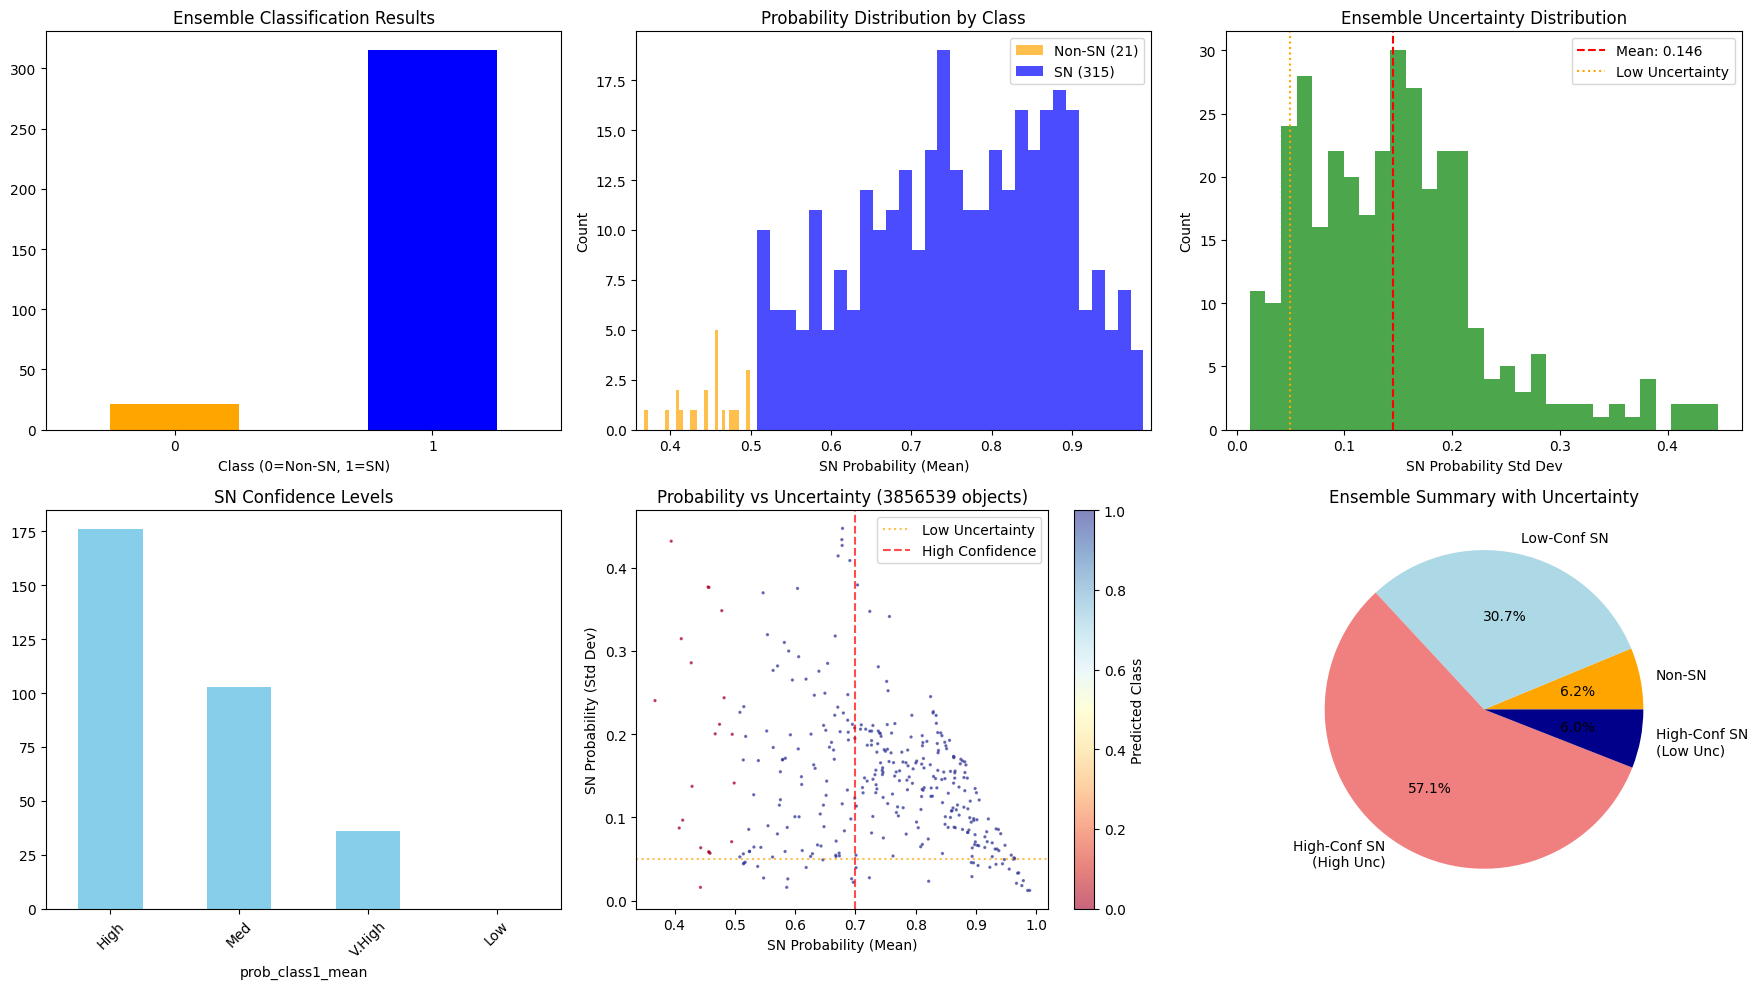


Ensemble Summary:
SNN-processed objects: 3856539
Total objects in dataset: 3856539
High-confidence SN candidates: 212
High-conf + Low uncertainty: 20
Mean uncertainty: 0.146
Objects with high uncertainty (>0.1): 223


In [2]:
r = dataset.lightcurves.inference_snn

Found 105 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 2661


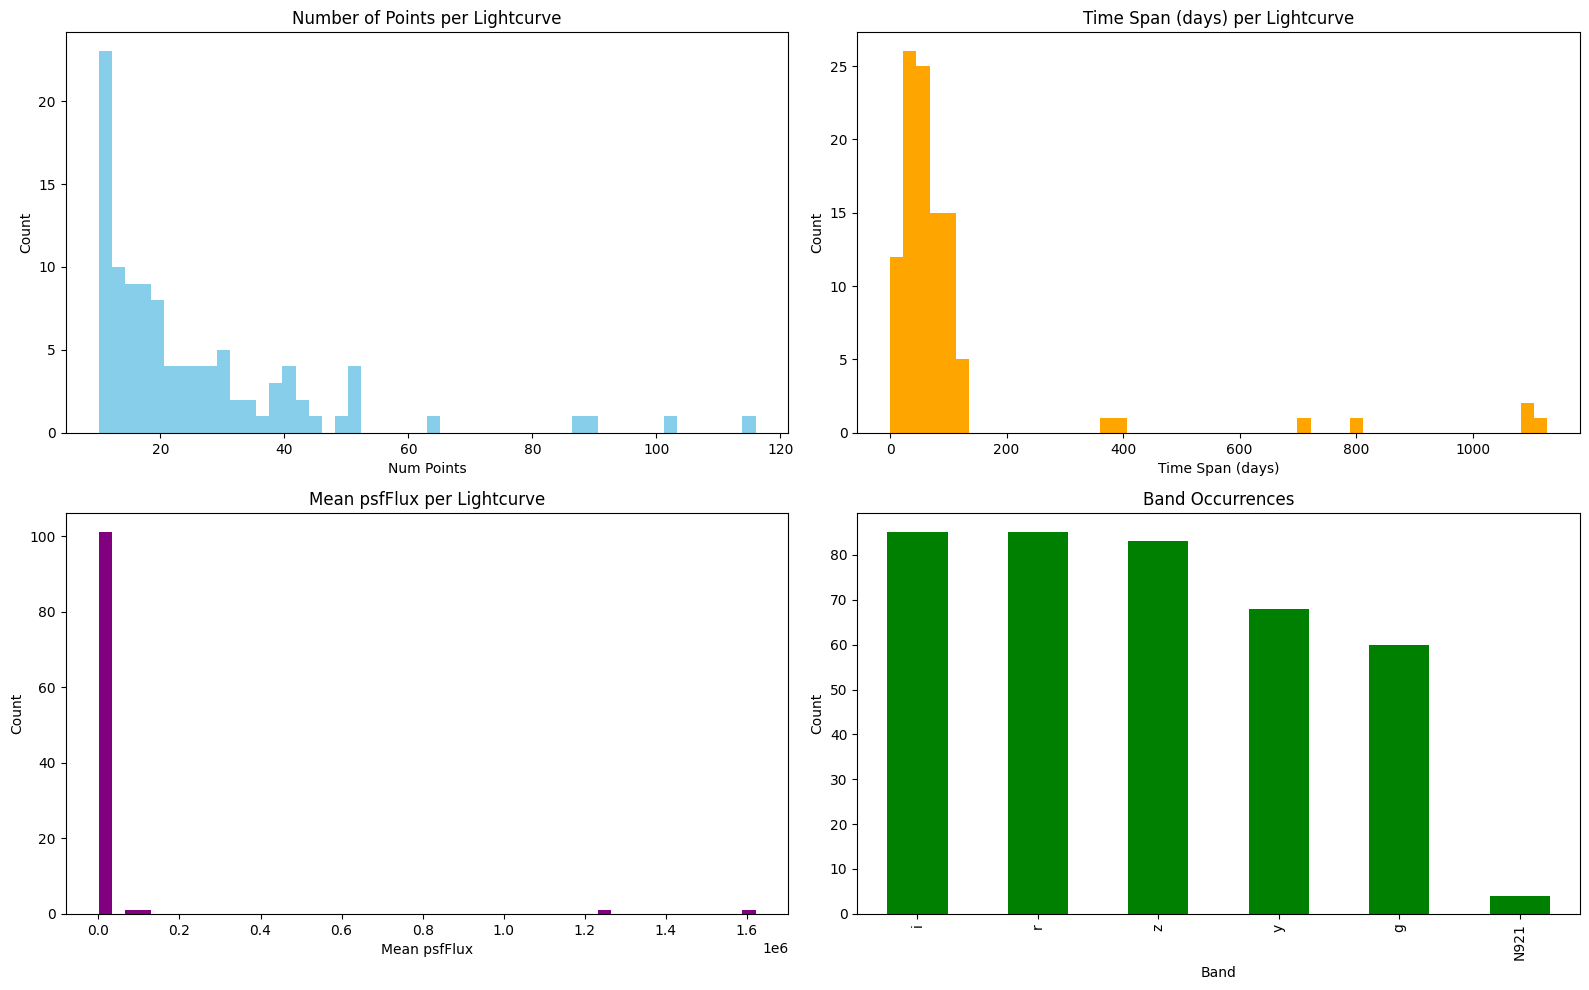

{'num_lightcurves': 105, 'num_points': {'mean': 25.34285714285714, 'median': 19.0, 'std': 19.110121263191335, 'min': 10, 'max': 116}, 'time_span_days': {'mean': 106.46852525060739, 'median': 60.981278391205706, 'std': 203.21270461298124, 'min': 0.08130277198506519, 'max': 1127.902769953711}, 'mean_psf_flux': {'mean': 31520.866031911584, 'median': 960.9425143871578, 'std': 197669.25012663883, 'min': 235.40816688815974, 'max': 1621239.6222807483}, 'bands': {'unique': ['y', 'g', 'r', 'i', 'N921', 'z'], 'counts': {'i': 85, 'r': 85, 'z': 83, 'y': 68, 'g': 60, 'N921': 4}}}


In [3]:
high_conf = list(dataset.lightcurves.get_high_conf_sn_sources(prob_threshold=0.5, std_threshold=0.1))

diasource_index = dataset.lightcurves.diasource_index
# This will get the unique diaObjectIds corresponding to your high-confidence sources
high_conf_obj_ids = list(set(diasource_index.loc[
    diasource_index.index.isin(high_conf), 'diaObjectId'
]))

stats_dict = dataset.lightcurves.summarize_multiple_lightcurves(high_conf_obj_ids)
print(stats_dict)

Found 449 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 8242


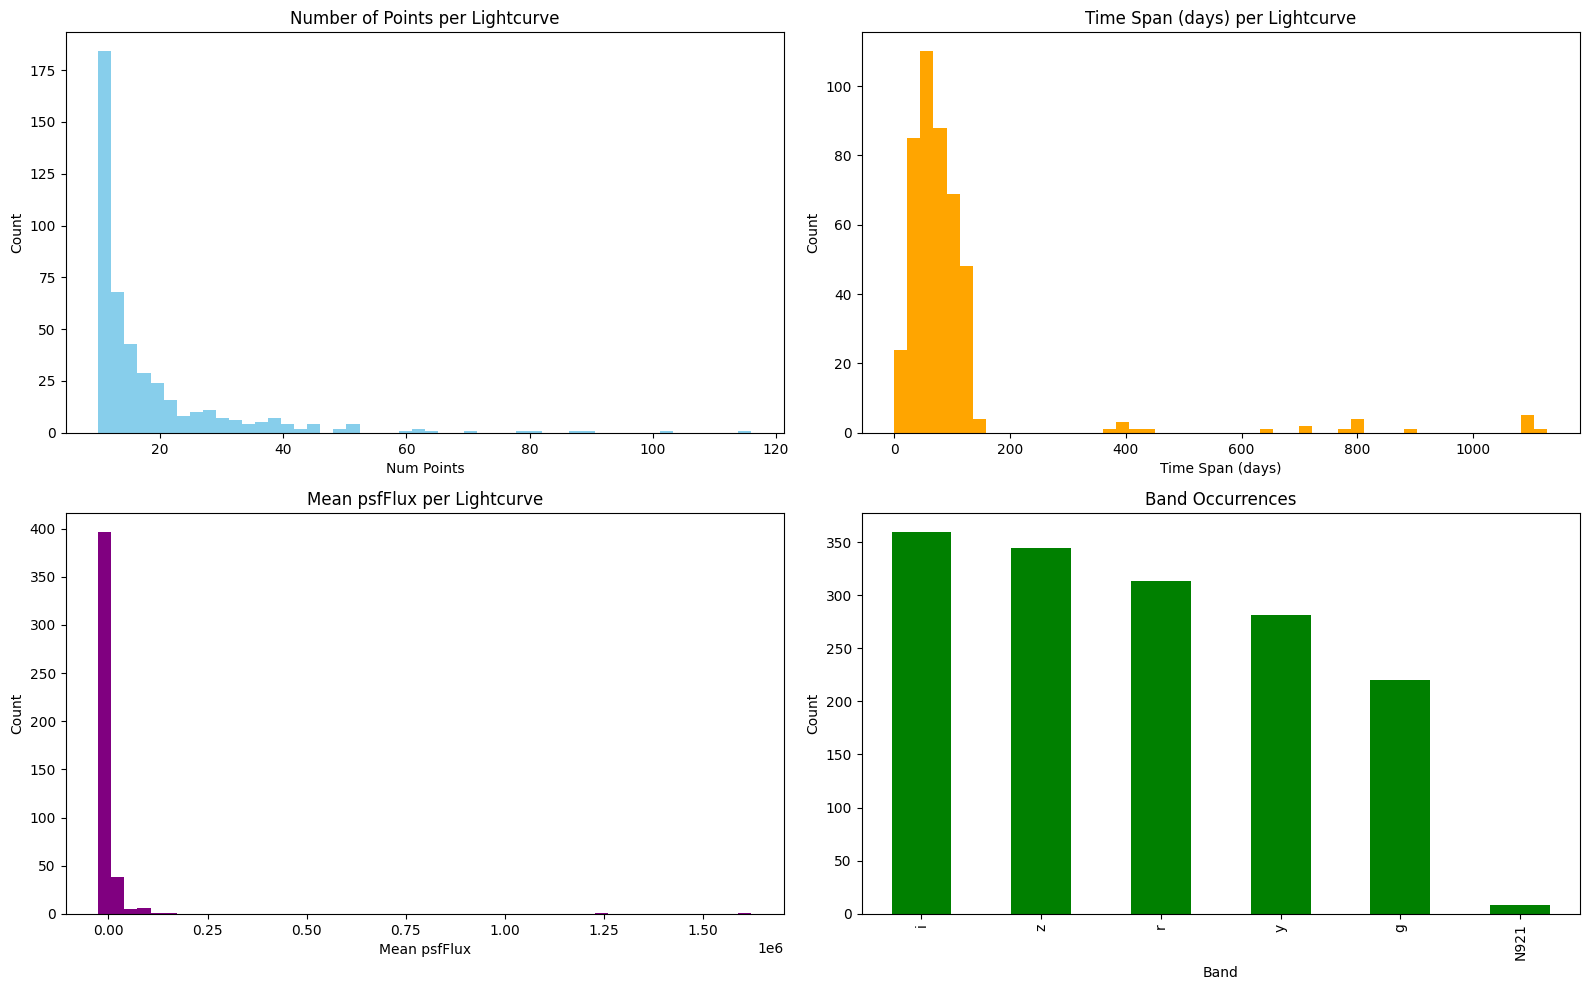

{'num_lightcurves': 449, 'num_points': {'mean': 18.356347438752785, 'median': 13.0, 'std': 13.227745054242751, 'min': 10, 'max': 116}, 'time_span_days': {'mean': 102.3054888785656, 'median': 69.89873116898525, 'std': 160.0333985852665, 'min': 0.08130277198506519, 'max': 1127.902769953711}, 'mean_psf_flux': {'mean': 10651.428850543305, 'median': 700.8829371603704, 'std': 97268.3648387036, 'min': -25293.336595084944, 'max': 1621239.6222807483}, 'bands': {'unique': ['g', 'i', 'r', 'z', 'N921', 'y'], 'counts': {'i': 359, 'z': 344, 'r': 313, 'y': 281, 'g': 220, 'N921': 8}}}


In [11]:
high_conf = list(dataset.lightcurves.get_high_conf_sn_sources(prob_threshold=0.5, std_threshold=0.3))

diasource_index = dataset.lightcurves.diasource_index
# This will get the unique diaObjectIds corresponding to your high-confidence sources
high_conf_obj_ids = list(set(diasource_index.loc[
    diasource_index.index.isin(high_conf), 'diaObjectId'
]))

stats_dict = dataset.lightcurves.summarize_multiple_lightcurves(high_conf_obj_ids)
print(stats_dict)

In [4]:
dataset.lightcurves.save_high_conf_subset_dataset("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_coadd_SNN_v3", prob_threshold=0.5, std_threshold=0.3)

Found 302 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 6106
Saving 6106 high-confidence SN sources to mini-dataset.
Saved filtered lightcurve_index.h5: 302 entries
Saved filtered diasource_patch_index.h5: 6106 entries
Found 302 high-confidence diaObjectIds
No high-confidence sources found in patch_9813_9.h5
Saved 21 lightcurve sources to patch_9813_2.h5
Saved 217 lightcurve sources to patch_9813_52.h5
No high-confidence sources found in patch_9813_75.h5
Saved 238 lightcurve sources to patch_9813_40.h5
Saved 97 lightcurve sources to patch_9813_24.h5
Saved 91 lightcurve sources to patch_9813_20.h5
Saved 183 lightcurve sources to patch_9813_38.h5
Saved 135 lightcurve sources to patch_9813_21.h5
No high-confidence sources found in patch_9813_18.h5
Saved 10 lightcurve sources to patch_9813_71.h5
No high-confidence sources found in patch_9813_79.h5
Saved 130 lightcurve sources to patch_9813_42.h5
Saved 90 lightcurve sources to patch_9813_41.h5
Saved 85 li

# Cross matching


## High conf


In [1]:
small_ds = DatasetLoader("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_coadd_SNN_v3")
small_ds._discover_data()

NameError: name 'DatasetLoader' is not defined

In [5]:
small_ds = DatasetLoader("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_coadd_SNN_v2")
nogaia = small_ds.filter_by_crossmatch('source_cat_gaia', matched=False)
small_ds = DatasetLoader("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_coadd_SNN_v2")
agn = small_ds.filter_by_crossmatch('milliquas_filtered', matched=True)
print(f'Not a star: {len(nogaia)}, an agn {len(agn)}')

Loaded cross-match data for 449 objects
Loaded cross-match data for 449 objects
Not a star: 334, an agn 23


In [9]:
transients =set(nogaia) - set(agn)

for x in transients:
    print(x)

3495809259583582208
3495901618560344064
3495892822467315717
3495906016606835742
3496099530653323298
3495954395118512164
3496068744327762982
3496059948234726439
3495853240048707626
3495949997071960106
3495971987304526890
3496055550188253230
3496046754095204400
3495844443955675184
3495971987304549426
3495985181444046900
3495826851769657398
3496015967769632823
3495963191211501629
3495826851769646143
3496033559955704902
3496024763862630474
3495914812699912270
3496095132606822481
3496095132606819415
3495971987304539225
3496007171676587106
3495949997071963237
3496103928699856998
3495936802932415595
3495888424420878447
3496029161909199984
3495914812699915377
3496064346281242742
3495954395118508150
3495901618560343162
3496068744327781508
3496055550188233861
3496011569723115655
3495862036141739143
3495963191211518092
3495866434188258444
3495989579490561167
3496086336513796240
3495989579490561168
3495866434188264608
3496015967769630882
3495941200978915492
3496108326746371255
3496033559955696825


In [9]:
for i in nogaia:
    print(i)

3496029161909218091
3495976385351006424
3495976385351019030
3495906016606835778
3495906016606838787
3495906016606839883
3495906016606843127
3495888424420857919
3495888424420867657
3495888424420887788
3495967589258005654
3495967589258009422
3495967589258014460
3495967589258016524
3495892822467314205
3495892822467320562
3496112724792855090
3496112724792857537
3495985181444042443
3495985181444044505
3495985181444047538
3495945599025457065
3495945599025463841
3496046754095203202
3496090734560315335
3496090734560319202
3496090734560320819
3496086336513793850
3496086336513793860
3496086336513797153
3496095132606818918
3496095132606821418
3496095132606825171
3496095132606827313
3495862036141715830
3495862036141729733
3495928006839402923
3496143511118432745
3496143511118433352
3495897220513822327
3495897220513822626
3496068744327776980
3496068744327781295
3495971987304537630
3495971987304543597
3495818055676621387
3495963191211497507
3496007171676610077
3495853240048708674
3495923608792933337


In [10]:
for i in agn:
    print(i)

3495976385351025819
3495906016606839094
3495888424420898774
3495985181444047538
3495945599025457461
3495945599025479796
3496046754095217818
3496046754095217938
3496090734560319202
3496095132606820418
3495971987304562553
3496007171676619078
3495923608792948168
3496099530653325421
3495949997071967555
3495949997071971839
3495949997071973741
3495936802932425393
3495910414653355215
3495910414653359589
3495954395118469515
3496103928699850834
3495901618560353722


## Udeep

In [ ]:
gaia_stars = dataset.filter_by_crossmatch('source_cat_gaia', matched=True)
transient_candidates = dataset.filter_by_crossmatch('source_cat_gaia', matched=False)

In [ ]:
for i in gaia_stars:
    print(i)